In [38]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm
from langchain_openai import AzureOpenAIEmbeddings
import json
import numpy as np
import torch
import time
import random
import ast
import matplotlib.pyplot as plt
from collections import defaultdict

import os

Let's fetch the dataframes.

In [39]:
from data_extractor import Extractor
extractor_instance = Extractor()
extractor_instance.extract(location="./data/results/df_combined.csv")

df_combined = pd.read_csv("data/results/df_combined.csv")
df_combined.sample(n=3)

Comp domain df length: 1912  - VTT domain df length: 4927
Example of text to compare: FiR 1 - FiR 1 is a Triga-type nuclear research reactor located in Otaniemi, Espoo, Finland, decommissioned by VTT after serving since 1962, used for nuclear research, training, and medical radiation therapy. | Developed by VTT Technical Research Centre of Finland Ltd.


,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,target type,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company
3524,3524,VTT879,FI27256903,The Biofoundry innovation is developed by VTT ...,Biofoundry,Innovation,Biofoundry,An innovative biological production process us...,DEVELOPED_BY,FI26473754,Organization,VTT Technical Research Centre of Finland,A Finnish research organization specializing i...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Biofoundry - An innovative biological producti...,NaN,NaN
796,796,VTT191,FI27256903,Kumera Corporation contributed to the developm...,VTT:n uudella menetelmällä metsätähteistä...,Innovation,VTT:n uudella menetelmällä metsätähteistä...,A new gasification method developed by VTT for...,DEVELOPED_BY,temp_1245,Organization,Kumera Corporation,An organization involved in the BTL2030 biomas...,https://www.vttresearch.com/fi/uutiset-ja-tari...,Hyppää pääsisältöön Beyond the obvious ...,VTT:n uudella menetelmällä metsätähteistä...,NaN,NaN
6005,6005,COMP727,NaN,The plastic-free packaging innovation for bed ...,muoviton pakkaus vuodetekstiileissä,Innovation,muoviton pakkaus vuodetekstiileissä,A new plastic-free packaging made of corrugate...,DEVELOPED_BY,FI18328493,Organization,Finlayson,A company engaged in textile production and su...,https://www.finlayson.fi/blogs/finlayson/nain-...,\n LoistopÃ¤ivÃ¤t vain sunnunta...,muoviton pakkaus vuodetekstiileissä - A new pl...,3964.0,MANNA & CO OY


In [40]:
from embedding_generator import EmbeddingGenerator, LocalEmbeddingProvider, OpenAIEmbeddingProvider

# Configuration
METHOD = "openai"  # Supports local and openai
MODEL_NAME = "all-mpnet-base-v2"  # For local embeddings
MODEL_KEY = "gpt-4.1-mini"  # For OpenAI embeddings, I think only this works

# File paths
input_file = "data/results/df_combined.csv"
output_file = "data/results/embeddings.csv"

provider = OpenAIEmbeddingProvider(MODEL_KEY) if METHOD == "openai" else LocalEmbeddingProvider(MODEL_NAME)
generator = EmbeddingGenerator(provider)

result_df = None
recreate_embeddings = False
if os.path.exists(output_file) and not recreate_embeddings:
    result_df = pd.read_csv(output_file)
    print(f"Loaded {len(result_df)} pairs from {output_file}")
else:
    result_df = generator.generate_embeddings(input_file, output_file)

result_df["embedding"] = result_df["embedding"].apply(ast.literal_eval)

2025-05-31 19:59:46,810 - INFO - Initialized OpenAI embedding model with key: gpt-4.1-mini


Loaded 6839 pairs from data/results/embeddings.csv


In [41]:
result_df.head()

,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,...,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company,embedding,embedding_provider,embedding_dimension
0,0,VTT0,FI10292588,"FiR 1 nuclear research reactor was developed, ...",FiR 1,Innovation,FiR 1,FiR 1 is a Triga-type nuclear research reactor...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,FiR 1 - FiR 1 is a Triga-type nuclear research...,NaN,NaN,"[-0.018910497426986694, 0.017533520236611366, ...",openai_gpt-4.1-mini,3072
1,1,VTT0,FI10292588,Centre for Nuclear Safety is being developed a...,Centre for Nuclear Safety,Innovation,Centre for Nuclear Safety,A modern research facility under construction ...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Centre for Nuclear Safety - A modern research ...,NaN,NaN,"[-0.009751166217029095, 0.006150579079985619, ...",openai_gpt-4.1-mini,3072
2,2,VTT3,FI08932048,The innovation approach 'Beyond the obvious' i...,Beyond the obvious,Innovation,Beyond the obvious,An innovation approach promising to provide so...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd,A visionary research and innovation partner fo...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Beyond the obvious - An innovation approach pr...,NaN,NaN,"[-0.02210899069905281, -0.002120873425155878, ...",openai_gpt-4.1-mini,3072
3,3,VTT4,FI01111693,Data-Driven Bioeconomy project is developed by...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland,A Finnish research and innovation partner work...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.015033945441246033, 0.031899139285087585, ...",openai_gpt-4.1-mini,3072
4,4,VTT4,FI01111693,Data-Driven Bioeconomy project's forestry pilo...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,temp_1141,...,MHG Systems,An organization leading pilots developing fore...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.014490003697574139, 0.016991155222058296, ...",openai_gpt-4.1-mini,3072


Original embedding shape: (6839, 3072)
After PCA: (100, 2)
PCA explained variance ratio: [0.13314207 0.10311834]
Total variance explained: 0.2363


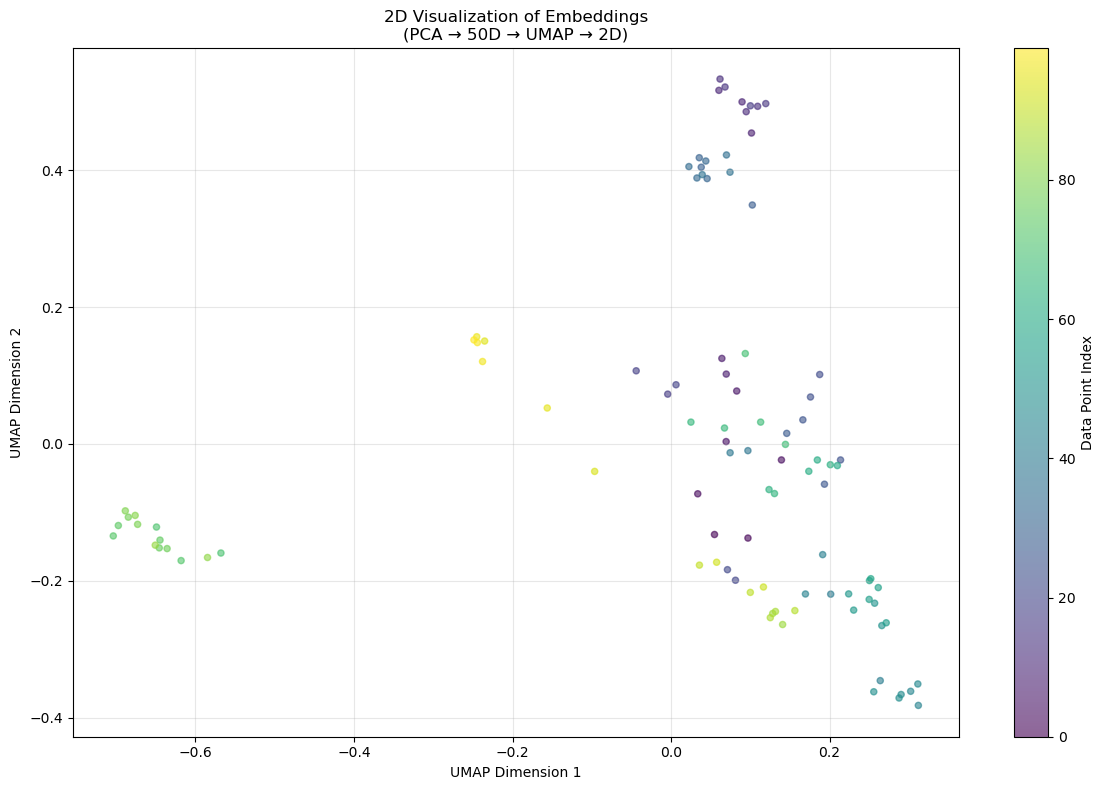

In [21]:
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import numpy as np

# Extract embeddings from the dataframe (assuming result_df is your dataframe with 'embedding' column)
embeddings_array = np.array(result_df['embedding'].tolist())

print(f"Original embedding shape: {embeddings_array.shape}")

# Step 1: Reduce dimensions to 50 using PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings_array[:100])
print(f"After PCA: {embeddings_2d.shape}")
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Step 3: Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     alpha=0.6, s=20, c=range(len(embeddings_2d)), cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Embeddings\n(PCA → 50D → UMAP → 2D)')
plt.colorbar(scatter, label='Data Point Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [42]:
def calculate_similar_pairs(embeddings_tensor, threshold=0.8, verbose=True):

    similar_pairs = []

    # Compute cosine similarity matrix
    cos_sim_matrix = util.cos_sim(embeddings_tensor, embeddings_tensor)

    # Get indices of upper triangle (i < j)
    triu_indices = torch.triu_indices(cos_sim_matrix.size(0), cos_sim_matrix.size(1), offset=1)

    # Get similarity scores for upper triangle
    sim_scores = cos_sim_matrix[triu_indices[0], triu_indices[1]]

    # Filter by threshold
    mask = sim_scores > threshold
    i_indices = triu_indices[0][mask].tolist()
    j_indices = triu_indices[1][mask].tolist()
    scores = sim_scores[mask].tolist()

    # Collect similar pairs
    similar_pairs = [(i, j, score) for i, j, score in zip(i_indices, j_indices, scores)]
    
    return similar_pairs, scores

def create_embeddings_tensor(duplicates=False):
    result_df_final = result_df.copy()
    if duplicates == False:
        result_df_final = result_df.drop_duplicates(subset=["source description"]).reset_index(drop=True)

    combined_embeddings = result_df_final["embedding"].tolist()
    combined_texts = result_df_final["text_to_compare"].tolist()

    start_time = time.time()
    embeddings_tensor = torch.stack([torch.tensor(e) for e in combined_embeddings])
    return embeddings_tensor, combined_texts, combined_embeddings, result_df_final

def save_duplicates(dup_df):
    duplicates = dup_df[dup_df.duplicated("source description", keep=False)]
    # Drop unwanted columns if they exist
    columns_to_drop = [col for col in ["Source Text", "embedding"] if col in duplicates.columns]
    duplicates = duplicates.drop(columns=columns_to_drop)
    # Save to CSV
    duplicates.to_csv("data/results/duplicates.csv", index=False)
    print(len(duplicates), "was the length of duplicates in total")

    

Last datapoint: 27, 0.9940291532763729


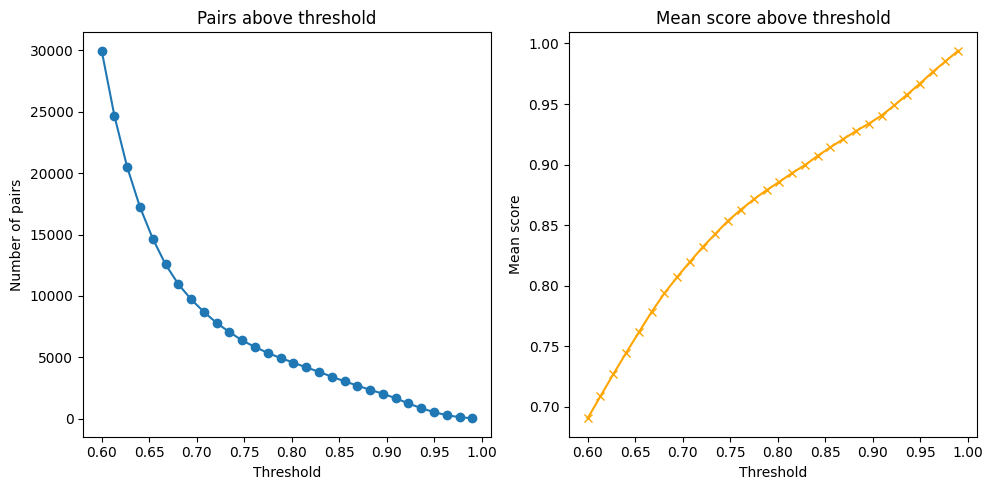

In [43]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
mean_scores = []

embeddings_tensor, combined_texts, combined_embeddings, mutated_result_df = create_embeddings_tensor()

for threshold in thresholds:
    similar_pairs, scores = calculate_similar_pairs(embeddings_tensor, threshold=threshold)
    pair_counts.append(len(similar_pairs))
    mean_scores.append(np.mean(scores) if scores else 0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_scores[-1]}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds, pair_counts, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of pairs')
plt.title('Pairs above threshold')

plt.subplot(1, 2, 2)
plt.plot(thresholds, mean_scores, marker='x', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Mean score')
plt.title('Mean score above threshold')

plt.tight_layout()
plt.show()

# Let's group the pairs

In [44]:
def group_similar_pairs(similar_pairs):
    
    # Create adjacency list representation
    graph = defaultdict(set)
    
    # Build the graph from pairs
    for i, j, score in similar_pairs:
        graph[i].add(j)
        graph[j].add(i)
     
    # Find connected components using DFS
    visited = set()
    groups = []
    
    def dfs(node, current_group):
        if node in visited:
            return
        visited.add(node)
        current_group.add(node)
        
        # Visit all neighbors
        for neighbor in graph[node]:
            dfs(neighbor, current_group)
    
    # Find all connected components
    for node in graph:
        if node not in visited:
            current_group = set()
            dfs(node, current_group)
            if current_group:  # Only add non-empty groups
                groups.append(current_group)
    
    return groups



In [45]:
import random
similar_pairs, scores = calculate_similar_pairs(embeddings_tensor)
groups_sorted = group_similar_pairs(similar_pairs)
# Ensure there are at least 5 groups
num_samples = min(5, len(groups_sorted))
random_groups = random.sample(groups_sorted, num_samples)

print(f"\nSample of 10 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")


Sample of 10 random groups:

Group 1 (size: 6):
  Index 2671: INLOOK GLAZY DOUBLE - Double-glazed sound insulating glass wall for conference rooms and other premi...
  Index 2673: INLOOK SLIDY dB - Sound insulating sliding glass wall for premises with sound insulation requirement...
  Index 2679: INLOOK CONFERENCE ROOM - Modular sound insulated conference room with glass front wall, sound absorb...
  Index 3016: INLOOK GLAZY DOUBLE - Double-glazed sound insulating glass wall offering good sound insulation value...
  Index 3018: INLOOK SLIDY dB - Sound insulating sliding glass wall designed for premises with sound insulation re...
  Index 3024: INLOOK CONFERENCE ROOM - Modular sound insulated conference room with glass front, sound absorbing p...

Group 2 (size: 2):
  Index 2037: NEMO - NEMO is a four-year EU Horizon 2020 funded project starting in 2018, coordinated by VTT, aimi...
  Index 2041: NEMO - A four-year Horizon 2020 EU-funded project starting earliest spring 2018 aiming to o

Last datapoint: 26, 2.0384615384615383


<Figure size 1000x500 with 0 Axes>

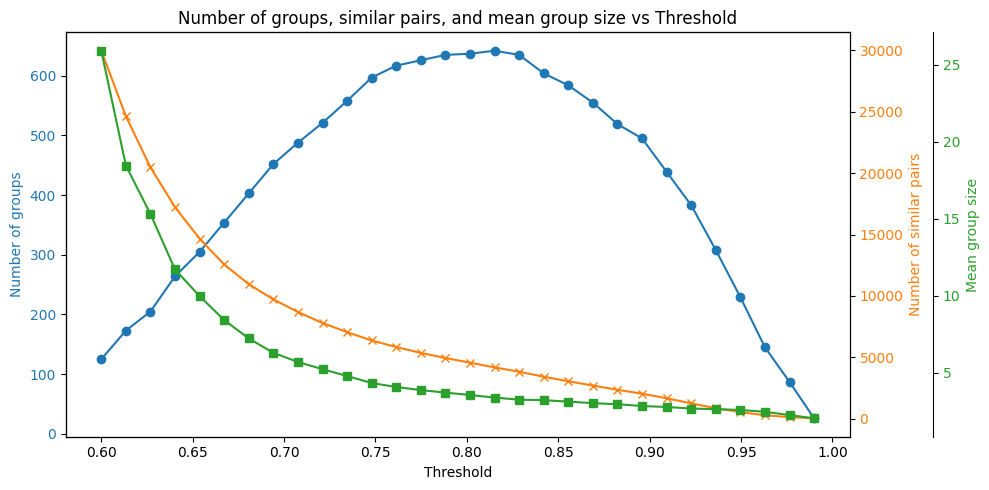

In [46]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
pair_sizes = []
mean_group_sizes = []

for threshold in thresholds:
    
    similar_pairs, scores = calculate_similar_pairs(embeddings_tensor, threshold)
    groups = group_similar_pairs(similar_pairs)
    pair_counts.append(len(groups))
    pair_sizes.append(len(similar_pairs))  # Track number of similar pairs
    if groups:
        mean_group_sizes.append(np.mean([len(g) for g in groups]))
    else:
        mean_group_sizes.append(0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_group_sizes[-1]}")

plt.figure(figsize=(10, 5))
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of groups', color=color)
ax1.plot(thresholds, pair_counts, marker='o', color=color, label='Number of groups')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of similar pairs', color=color)
ax2.plot(thresholds, pair_sizes, marker='x', color=color, label='Number of similar pairs')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Mean group size', color=color)
ax3.plot(thresholds, mean_group_sizes, marker='s', color=color, label='Mean group size')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Number of groups, similar pairs, and mean group size vs Threshold')
fig.tight_layout()
plt.show()

# Let's create the final groups and graph

In [47]:
embeddings_tensor, combined_texts, combined_embeddings, result_df_mutated = create_embeddings_tensor()

In [48]:
similar_pairs_final, scores_final = calculate_similar_pairs(embeddings_tensor, threshold=0.8)
print("original amount of rows", len(result_df))
save_duplicates(result_df)

original amount of rows 6839
4225 was the length of duplicates in total


In [56]:
groups_final = group_similar_pairs(similar_pairs_final)
groups_final_saved = [ list(x) for x in groups_final]
with open("data/results/groups_final.json", "w") as f:
    json.dump(groups_final_saved, f) 


In [59]:
groups_final = None
with open("data/results/groups_final.json", "r") as f:
    groups_final = json.load(f)
    groups_final = [set(x) for x in groups_final]

random_groups = random.sample(groups_final, 10)

print(f"\nSample of 10 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")


Sample of 10 random groups:

Group 1 (size: 3):
  Index 1830: Älykäs kaukolämpö- ja jäähdytysverkko - An intelligent district heating and cooling network that ena...
  Index 1833: Älykäs lämmonjakokeskus palveluna - Smart heat distribution center as a service, an innovation that ...
  Index 2617: älykäs kaukolämpö- ja jäähdytysverkko - A smart district heating and cooling network that enables th...

Group 2 (size: 4):
  Index 2851: administrative case management solution for the Social Insurance Institution of Finland - A case man...
  Index 2860: Administrative case management solution for the Social Insurance Institution of Finland - An adminis...
  Index 2875: hallinnollinen asianhallintaratkaisu Kansaneläkelaitokselle - Administrative case management solutio...
  Index 2893: Kansaneläkelaitos (Kela), hallinnollisen asianhallintaratkaisun toimittajuus SaaS -palveluna - A del...

Group 3 (size: 2):
  Index 2982: anchoring method - A novel method to anchor steel-structured fabric bui

Now validate groups

In [65]:
from pydantic import BaseModel
from typing import List
from langchain_openai import AzureChatOpenAI
import asyncio
from langchain.schema import HumanMessage, SystemMessage


class FalsePositives(BaseModel):
    reasoning: str = ""
    innovations: List[int] = []
    

SYSTEM_PROMPT = """You are an expert innovation analyst. 

You will receive groups of innovations that were identified as potential duplicates based on similarity.

Your task: Identify which innovation numbers are NOT duplicates (distinct innovations).

Return only the numbers of innovations that represent different projects/technologies."""

def create_user_prompt(group_indices, combined_texts, result_df):
    """Create simple user prompt"""
    
    innovations_text = ""
    for i, idx in enumerate(sorted(group_indices), 1):
        innovation_text = combined_texts[idx]
        innovations_text += f"{i}. {innovation_text}\n\n"

    return f"""Which innovations are NOT duplicates?

{innovations_text}Return the numbers of distinct innovations."""

def initialize_llm(deployment_model:str, config_file_path:str= 'data/keys/azure_config.json')->AzureChatOpenAI: 
    with open(config_file_path, 'r') as jsonfile:
        config = json.load(jsonfile)
    
    return AzureChatOpenAI(model =deployment_model,
                    api_key=config[deployment_model]['api_key'],
                    azure_endpoint = config[deployment_model]['api_base'],
                    api_version = config[deployment_model]['api_version'])

# Initialize with structured output
llm = initialize_llm(deployment_model="gpt-4.1-mini").with_structured_output(FalsePositives)

async def evaluate_group(group, combined_texts, result_df):
    
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=create_user_prompt(group, combined_texts, result_df))
    ]
    
    result = await llm.ainvoke(messages)
    
    print(create_user_prompt(group, combined_texts, result_df))
    print("RESULT ----", result)

    return {
        "group_indices": list(group),
        "false_positives": result.innovations,
        "reasoning": result.reasoning
    }

# Process all groups
async def evaluate_all_groups(groups, combined_texts, result_df):
    """Process all groups with 2+ innovations"""
    i = 0
    tasks = []
    for i, group in enumerate(groups):
        if len(group) >= 2:
            tasks.append(evaluate_group(group, combined_texts, result_df))
            break
    results = await asyncio.gather(*tasks)
    return results

In [66]:
results = await evaluate_all_groups(groups_final, combined_texts, result_df)

# now we can see the results
for result in results:
   print(result)
   
with open("./data/results/results_with_reasoning.json", "w") as f:
   json.dump(results, f, indent=2)
   

2025-05-31 20:23:05,129 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


Which innovations are NOT duplicates?

1. FiR 1 - FiR 1 is a Triga-type nuclear research reactor located in Otaniemi, Espoo, Finland, decommissioned by VTT after serving since 1962, used for nuclear research, training, and medical radiation therapy. | Developed by VTT Technical Research Centre of Finland Ltd.

2. FiR 1 -tutkimusreaktorin käytöstä poisto - The decommissioning and dismantling of the FiR 1 research reactor in Espoo, Finland, including safe removal of radioactive materials and structures, conducted under regulatory supervision and completed in phases. | Developed by VTT

3. FiR1-ydinreaktorin purkuprojekti - The decommissioning project of Finland's oldest nuclear research reactor FiR1, completed in Espoo, establishing a national mechanism for nuclear facility decommissioning and waste management, serving as a model for future reactor decommissionings. | Developed by VTT

4. FiR1-ydinreaktori - Finland's oldest nuclear research reactor located at VTT's Otaniemi premises, de

In [88]:
groups_final_final = []
final_results = None

with open("./data/results/results.json", "r") as f:
    final_results = json.load(f)

nondup_results_df = result_df.drop_duplicates(subset=["source description"]).reset_index(drop=True)

for res in final_results:
    members = res["group_indices"]
    to_exclude = res["false_positives"]
    diff = list(set(members) - set(to_exclude))
    groups_final_final.append(diff)
    
groups_final_final = [[nondup_results_df.iloc[idx] for idx in y] for y in groups_final_final]

groups_json = [
    [
        {k: v for k, v in row.to_dict().items() if k not in ["embedding", "Source Text"]}
        for row in group
    ]
    for group in groups_final_final
]

with open("groups_final_final.json", "w") as f:
    json.dump(groups_json, f, indent=2)
